In [ ]:
!pip install langchain==0.1.1 openai==1.8.0 langchain-openai tiktoken faiss-cpu
!pip install PyPDF

In [2]:
from google.colab import files
from IPython.display import Image

In [3]:
import os
import getpass
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

In [4]:
os.environ["OPENAI_API_KEY"] = getpass.getpass('Enter API Key ')

Enter API Key ··········


Suppose you want to obtain very specific information from your own documents or proprietary information, and you decide to use Chat-GPT to ask for it. The obvious response you will receive is, "I can't access specific personal data, including financial information." This is where LangChain comes in to shine. LangChain is an open-source orchestration framework utilized for developing applications with Large Language Models. It facilitates the integration of LLMs with custom sources of computation and data.

To accomplish this, we input the documents we want the language model to reference. We then divide them into smaller chunks using Recursive Character Text Splitter, convert them into embeddings to characterize each piece of text based on its semantic meaning, and store them as a vector database.

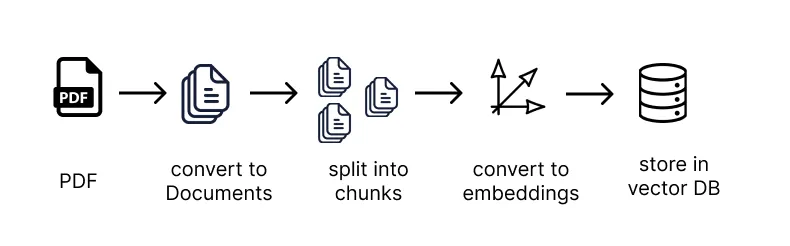

In [ ]:
files.upload()
Image("image.png")

Image Scouce: https://betterprogramming.pub/building-a-multi-document-reader-and-chatbot-with-langchain-and-chatgpt-d1864d47e339')

In [21]:
class CustomLLM:
    pass

class Embedding(CustomLLM):
    def __init__(self, pdf_paths):
        self.pdf_paths = pdf_paths

    def load_pdf(self):                #upload documents, url
      self.pages = []
      for pdf_path in self.pdf_paths:
        fl = PyPDFLoader(pdf_path)
        pages = fl.load_and_split()
        self.pages.extend(pages)

    def chunking(self):               #splitting into small chunk
        text_chunking = RecursiveCharacterTextSplitter(
            chunk_size=1135,
            chunk_overlap=100,
            add_start_index=True,
            separators=['\n\n','\n','.',';',',',' ','','..'],
        )
        self.split = text_chunking.split_documents(self.pages)

    def embedding(self):               #embedding
        embedding = OpenAIEmbeddings()
        self.vectorstore = FAISS.from_documents(documents=self.split, embedding=embedding)

It's time to integrate external documents with the pre-trained large language model. We're leveraging OpenAI's GPT-4 for this purpose. We'll employ RetrievalQA to enhance the model's ability to generate responses grounded in a broader and more current understanding of the context.


In [22]:
class Chain(CustomLLM):
    def __init__(self, template, embedding_instance):
        self.template = template
        self.embedding_instance = embedding_instance

    def prompt_chain(self):
        QA_CHAIN_PROMPT = PromptTemplate.from_template(self.template)
        llm = ChatOpenAI(model_name="gpt-4-0125-preview", temperature=0)

        self.qa_chain = RetrievalQA.from_chain_type(
            llm,
            retriever=self.embedding_instance.vectorstore.as_retriever(),
            chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
        )

    def query(self, query_text):
        return self.qa_chain.invoke({"query": query_text})

In [23]:
template = """
Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say 'you don't know'. don't try to make up an answer.
Use five sentence maximum, relevent analogies, and keep the answer as concise as possible.
Use the active voice, and speak directly to the reader using concise language.
{context}

Question: {question}

Helpful Answer:

"""

In [24]:
path = ["sudip.pdf", "prevent_cancer.pdf", "image.pdf", "image_2023.pdf"]

In [ ]:
embedding_instance = Embedding(path)
embedding_instance.load_pdf()
embedding_instance.chunking()
embedding_instance.embedding()

In [13]:
chain_instance = Chain(template, embedding_instance)
chain_instance.prompt_chain()

We utilized our vector store as a source, which the chain accessed to retrieve only the relevant text based on our question. It then sent that information exclusively within the LLM prompt. The hierarchical image below illustrates the process transpiring in the background.

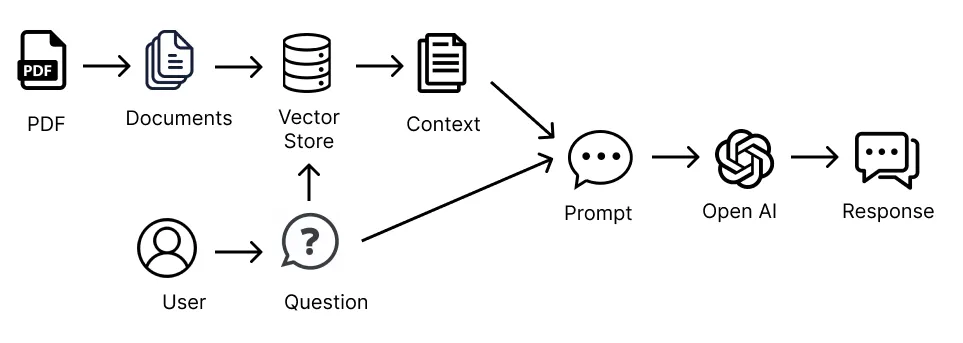

In [ ]:
files.upload()
Image('image3.png')

Image Scouce: https://betterprogramming.pub/building-a-multi-document-reader-and-chatbot-with-langchain-and-chatgpt-d1864d47e339')

In [14]:
chain_instance.query("What is the risk of cancer, If I smoke cigerate?")

{'query': 'What is the risk of cancer, If I smoke cigerate?',
 'result': "If you smoke cigarettes, your risk of developing cancer significantly increases. Smoking is directly responsible for a large percentage of cancer deaths, including 85% to 90% of lung cancer deaths and substantial percentages of deaths from oral, laryngeal, esophageal, bladder, kidney, pancreatic, stomach, and cervical cancers. The risk depends on several factors such as the duration of smoking, the number of cigarettes smoked per day, and the age at which you started smoking. However, quitting smoking at any age can reduce your risk of dying from smoking-related illnesses and can lower the risk of developing a second cancer if you've already been diagnosed with cancer. Cigarette smoke contains over 60 established carcinogens, including polycyclic aromatic hydrocarbons and N-nitrosamines, which are directly linked to increasing cancer risk."}

GPT-4 has been extensively trained on vast corpora of text, making it unsurprising that it can provide answers regarding cancer and cigarettes. To ensure the proper chaining of our embeddings and language models, I have incorporated a file containing personalized information not found on the web and not included in GPT's training data. This also guarantees its suitability for customers/internals question-answering applications tailored to our business needs.

In [ ]:
chain_instance.query("where was Sudip khadka born")

{'query': 'where was Sudip khadka born',
 'result': 'Sudip Khadka was born in Nepal.'}

In [ ]:
chain_instance.query("Does he has any degree")

{'query': 'Does he has any degree',
 'result': 'Yes, Sudip Khadka has a degree from the University of Maryland, College Park.'}

In [ ]:
chain_instance.query("What is his nationality")

{'query': 'What is his nationality',
 'result': "Sudip Khadka's nationality is Nepalese."}

This was just a simple example; now let's move on to the real use case. Although Arista Networks is a publicly traded company, for this scenario, we will treat it as if it were a private company. We agument latest 10-k's to our database, all files in the database are considered confidential and were not used during the training of GPT-4.

In [16]:
query = "what was the net income of Arista Network for 2022, 2023"
chain_instance.query(query)

{'query': 'what was the net income of Arista Network for 2022, 2023',
 'result': 'The net income of Arista Networks for 2022 was $1,352,446 (in thousands), and for 2023, it was $2,087,321 (in thousands).'}

In [15]:
query = "Who are the competitors of Arista Network?"
chain_instance.query(query)

{'query': 'Who are the competitors of Arista Network?',
 'result': 'Arista Networks, Inc. competes with several key players in the networking and data center industry. Major competitors include Cisco Systems, Inc., known for its vast range of networking hardware and software solutions. Juniper Networks, Inc. is another competitor, specializing in high-performance networking & cybersecurity solutions. Hewlett Packard Enterprise (HPE), through its networking division, also poses competition, offering similar networking hardware and software products. Lastly, VMware, Inc., with its focus on cloud computing and virtualization technology, competes in overlapping areas of network virtualization and management.'}

In [17]:
query = "How does the Arista Network performance compare to competitors?"
chain_instance.query(query)

{'query': 'How does the Arista Network performance compare to competitors?',
 'result': "Arista Networks differentiates itself from competitors through its focus on uncompromising quality, advanced open and standards-based technology, and a robust quality assurance capability. Its core, the Arista EOS, is a modernized networking operating system that, along with merchant silicon, provides a competitive edge in price/performance and time to market. Arista's platforms are designed for scalability, enabling networks to support hundreds of thousands of servers and millions of virtual machines efficiently. The use of merchant silicon helps Arista to quickly adapt to next-generation technologies, benefiting from improvements in performance and cost. Overall, Arista's approach to cloud networking solutions offers high capacity, performance, and scale, positioning it strongly against competitors."}

In [18]:
query = "What operational challenges and risks were highlighted for 2023 by Arista Network?"
chain_instance.query(query)

{'query': 'What operational challenges and risks were highlighted for 2023 by Arista Network?',
 'result': 'Arista Network highlighted operational challenges and risks for 2023 related to the need for operational efficiency and the total cost of ownership. The company emphasized the critical role of automation in achieving operational efficiency, pointing out that manual tasks in network management are burdensome and hinder agility in network infrastructure changes. Additionally, Arista underscored the importance of reducing the total cost of ownership through programmable, scalable leaf-spine architectures and applications that offer improved time to service and availability compared to legacy network designs. These challenges are addressed by Arista through their CloudVision management platform, which automates network operations, and their portfolio of products designed to lower networking costs and enhance operational efficiency.'}

In [19]:
query = "What are the strengths, weaknesses, opportunities, and threats of Arista Network for 2023?"
chain_instance.query(query)

{'query': 'What are the strengths, weaknesses, opportunities, and threats of Arista Network for 2023?',
 'result': 'Arista Networks, a leader in high-performance networking solutions, boasts strengths in its innovative technology and strong customer base in data centers and cloud computing. However, its weaknesses lie in intense competition from larger companies and potential supply chain disruptions. Opportunities for Arista include expansion into emerging markets and the growing demand for cloud networking solutions. Threats facing Arista in 2023 include technological obsolescence due to rapid industry advancements and potential regulatory challenges. In summary, while Arista is well-positioned with its innovative offerings, it must navigate a competitive landscape and external risks to maintain its growth trajectory.'}

In [ ]:
chain_instance.query(
    "What is the breakdown of assets, liabilities, and equity for 2023?")

{'query': 'What is the breakdown of assets, liabilities, and equity for 2023?',
 'result': "For 2023, the breakdown is as follows:\n\n- **Total Assets**: $6,775,410 thousand. This includes current assets like cash and cash equivalents, marketable securities, accounts receivable, inventories, and other current assets; long-term assets such as property and equipment, acquisition-related intangible assets, goodwill, investments, and other assets.\n  \n- **Total Liabilities**: $1,889,590 thousand. This encompasses current liabilities (accounts payable, accrued liabilities, deferred revenue, other current liabilities), income taxes payable, non-current operating lease liabilities, non-current deferred revenue, non-current deferred tax liabilities, and other long-term liabilities.\n\n- **Stockholders’ Equity**: The exact figure for stockholders' equity in 2023 isn't directly provided in the given context. However, it can be inferred by subtracting total liabilities from total assets, assumin

In [ ]:
chain_instance.query(
    "What are the future growth prospects and strategic plans?")

{'query': 'What are the future growth prospects and strategic plans?',
 'result': 'The company plans to expand its sales force, marketing efforts, and partnerships to drive growth. It aims to scale operations and manufacturing, invest in research and development, and adapt technology efficiently. The focus is on entering new markets like AI Ethernet switching, campus workspaces, enterprise data centers, and security markets, while maintaining leadership in the networking industry. Challenges include managing expansion, competition, price sensitivity, and external factors like geopolitical tensions and economic downturns. Overall, the company is optimistic about its growth prospects, leveraging innovation and market expansion strategies.'}

 Langchain serves as a versatile tool that goes beyond simply addressing customer inquiries. Its functionality extends to handling internal queries as well. Within an organizational context, Langchain can serve as a repository for a comprehensive knowledge base encompassing financial policies, procedures, and optimal practices. Moreover, it plays a pivotal role in addressing staff queries pertaining to financial policies and historical data that are restricted from external dissemination. By leveraging langchain, organizations can effectively streamline their internal operations while ensuring adherence to regulatory standards and promoting efficient decision-making processes.

  Further, To access the most up-to-date information beyond our internal database and pre-trained large language model, we can use Retrieval-Augmented Generation (RAG). This approach allows us to retrieve current data directly from web databases.

In [20]:
!jupyter nbconvert --to html /content/langChain-2.ipynb

[NbConvertApp] Converting notebook /content/langChain-2.ipynb to html
[NbConvertApp] Writing 658018 bytes to /content/langChain-2.html
